In [81]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
from scipy.spatial.distance import cdist
from heapq import heappush, heappop

import pandas as pd
from pyntcloud import PyntCloud

# conda install -c conda-forge pyntcloud
# conda install -c conda-forge pythreejs
# https://medium.com/analytics-vidhya/3d-cad-to-binary-voxel-numpy-array-b538d00d97da

import sys
sys.path.append('/Users/thor/surfdrive/Projects/FilamentsDNA/')
from voxelizer import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
tetra = md.load('./pdbs/tetra.pdb')
traj = tetra.atom_slice(tetra.top.select('chainid 0 1 2 3')).center_coordinates()
# view = nv.show_mdtraj(traj)
# view

In [179]:
def get_COM_selections(traj, QGR_resids):
    coms = []
    for ids in QGR_resids:
        selection = traj.top.select(f'resid {ids[0]} {ids[1]} {ids[2]}')
        com = md.compute_center_of_mass(traj.atom_slice(selection))
        coms.append(com)
    return np.array([list(l) for l in list(np.array(coms).swapaxes(0,1)[0])])


%matplotlib inline
V = Voxelizer(traj.xyz[0],n=50)
# get the coordinates of the center of mass of the QGR residues
QGR_resids = [[111,112,113],[248,249,250],[522,523,524],[385,386,387]] # for each chain the QGR residues
#QGR_resids = [[111,112,113],[385,386,387]] # for each chain the QGR residues
coms = get_COM_selections(traj, QGR_resids)
V.process_points(points=np.array(coms))
path = V.find_path(ordered=True)

Point [41 25 43] is inside voxel space. Moving to nearest zero voxel.
Point [41 25 43], 103793 is nearest zero voxel (41, 24, 42), 103742
Point [28 15 24] is inside voxel space. Moving to nearest zero voxel.
Point [28 15 24], 70774 is nearest zero voxel (27, 15, 24), 68274
Point [11 18 22] is inside voxel space. Moving to nearest zero voxel.
Point [11 18 22], 28422 is nearest zero voxel (10, 18, 22), 25922
Point [40 36  2] is inside voxel space. Moving to nearest zero voxel.
Point [40 36  2], 101802 is nearest zero voxel (40, 37, 2), 101852


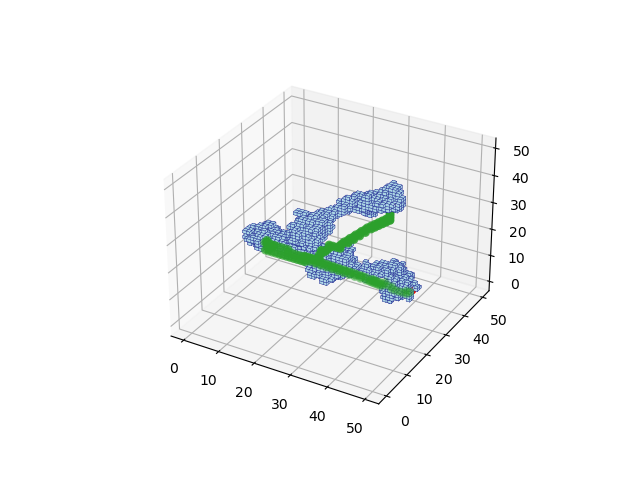

In [180]:
%matplotlib ipympl
# path = V.astar(tuple(V.control_points[1]), tuple(V.control_points[0]))

V.plot(path=np.array(path),control_points=True)

/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_59204/1936526106.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


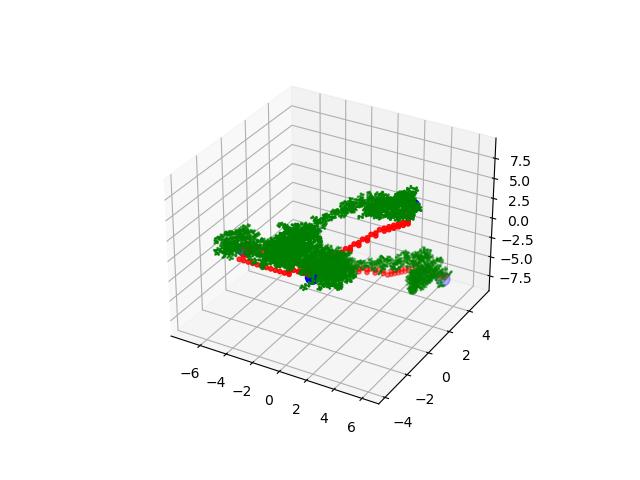

In [184]:
path_xyz = V.voxel_to_xyz(path)
fig = plt.figure()  
ax = fig.add_subplot(projection='3d')
ax.scatter3D(path_xyz[:,0], path_xyz[:,1], path_xyz[:,2], c='r', s=10)
ax.scatter3D(coms[:,0], coms[:,1], coms[:,2], c='b', s=100)
ax.scatter3D(traj.xyz[0,:,0], traj.xyz[0,:,1], traj.xyz[0,:,2], c='g', s=1)

In [ ]:
from heapq import heappush, heappop
from itertools import permutations

class VoxelPathfinder:
    def __init__(self):
        pass
                 
    def path_length(self, path):
        # Calculate the length of a path
        length = 0
        for i in range(1, len(path)):
            # Calculate the Euclidean distance between consecutive points in the path
            length += np.sqrt(sum((np.array(path[i]) - np.array(path[i-1])) ** 2))
        return length
    
    def heuristic(self, a, b):
        # Calculate the Euclidean distance (heuristic) between two points
        return np.sqrt(sum((np.array(a) - np.array(b)) ** 2))
    
    def astar(self, start, goal):
        neighbors = [(0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0), (0, 0, 1), (0, 0, -1)]
        close_set = set()  # Set to store explored nodes
        came_from = {}     # Dictionary to store the path for each node
        gscore = {start: 0}  # Dictionary to store the cost to reach each node from the start
        fscore = {start: self.heuristic(start, goal)}  # Dictionary to store the total estimated cost for each node
        oheap = []  # Priority queue to store nodes to be explored
        heappush(oheap, (fscore[start], start))  # Add the start node to the priority queue

        while oheap:
            current = heappop(oheap)[1]  # Get the node with the lowest estimated cost from the priority queue
            if current == goal:
                # Reconstruct the path from the goal node to the start node
                data = []
                while current in came_from:
                    data.append(current)
                    current = came_from[current]
                return data

            close_set.add(current)  # Mark the current node as explored
            for i, j, k in neighbors:
                neighbor = current[0] + i, current[1] + j, current[2] + k  # Calculate the coordinates of the neighbor node

                # Calculate the tentative cost to reach the neighbor node from the current node
                tentative_g_score = gscore[current] + self.heuristic(current, neighbor)

                if 0 <= neighbor[0] < self.voxel_grid.shape[0] and 0 <= neighbor[1] < self.voxel_grid.shape[1] and 0 <= neighbor[2] < self.voxel_grid.shape[2]:
                    if self.voxel_grid[neighbor[0]][neighbor[1]][neighbor[2]]:
                        continue
                else:
                    continue

                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                    continue

                if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + self.heuristic(neighbor, goal)
                    heappush(oheap, (fscore[neighbor], neighbor))

        return False

array([[-8.731026 , -7.445286 , -7.9354367],
       [-8.731026 , -7.445286 , -7.369973 ],
       [-8.731026 , -7.445286 , -6.80451  ],
       ...,
       [ 7.6674104,  8.95315  ,  7.332073 ],
       [ 7.6674104,  8.95315  ,  7.8975363],
       [ 7.6674104,  8.95315  ,  8.462999 ]], dtype=float32)

### Part 1: Convert pdb structure to a voxelgrid and assign DNA binding regions 

In [87]:
def xyz_to_binary_voxel(point_cloud, n=30, plot=False):
    """"Point cloud as N,3 numpy array of XYZ coordinates
        with n the number of voxels in each dimension of the voxel grid"""

    # create a dataframe with the atomic coordinates
    df = pd.DataFrame(data=point_cloud, columns=['x','y','z'])

    # create a PyntCloud object with the dataframe
    cloud = PyntCloud(df)

    # plot the point cloud  
    voxelgrid_id = cloud.add_structure("voxelgrid",n_x=n, n_y=n, n_z=n)
    voxelgrid = cloud.structures[voxelgrid_id]

    if plot:
        voxelgrid.plot(d=3, mode="density", cmap="hsv")

    # get the voxel grid as a numpy array as a binary array
    binary_voxel_array = voxelgrid.get_feature_vector(mode="binary")

    return voxelgrid, binary_voxel_array

def get_COM_selections(traj, QGR_resids):
    coms = []
    for ids in QGR_resids:
        selection = traj.top.select(f'resid {ids[0]} {ids[1]} {ids[2]}')
        com = md.compute_center_of_mass(traj.atom_slice(selection))
        coms.append(com)
    return np.array([list(l) for l in list(np.array(coms).swapaxes(0,1)[0])])


def get_voxel_indices(points, voxelgrid):
    # Calculate voxel indices based on the voxel grid segments 
    voxel_x = np.clip(np.searchsorted(voxelgrid.segments[0], points[:, 0]) - 1, 0, voxelgrid.x_y_z[0])
    voxel_y = np.clip(np.searchsorted(voxelgrid.segments[1], points[:, 1]) - 1, 0, voxelgrid.x_y_z[1])
    voxel_z = np.clip(np.searchsorted(voxelgrid.segments[2], points[:, 2]) - 1, 0, voxelgrid.x_y_z[2])

    # Convert voxel indices to voxel numbers
    voxel_n = np.ravel_multi_index([voxel_x, voxel_y, voxel_z], voxelgrid.x_y_z)

    # Get the unique voxel numbers of coms
    voxel_indices = np.array([voxel_x, voxel_y, voxel_z]).T

    return voxel_indices, voxel_n

def visualize_voxels(voxelgrid, voxel_n, ids, n):
    """
    Visualizes the voxels in a 3D plot.

    Args:
        voxelgrid (VoxelGrid): The voxel grid object.
        voxel_n (list): List of voxel indices.
        ids (list): List of voxel IDs.

    Returns:
        None
    """

    # Create boolean arrays to mark the presence of voxels
    # C: This boolean array marks the presence of all voxels in the voxel grid.
    # C_: This boolean array marks the presence of specific voxels identified by the voxel_n parameter.
    # C__: This boolean array marks the presence of specific voxels identified by the ids parameter.

    C = np.array([True if idx in voxelgrid.voxel_n else False for idx,_ in enumerate(voxelgrid.voxel_centers)]).reshape(n,n,n)
    C_ = np.array([True if idx in voxel_n else False for idx,_ in enumerate(voxelgrid.voxel_centers)]).reshape(n,n,n)
    C__ = np.array([True if idx in ids else False for idx,_ in enumerate(voxelgrid.voxel_centers)]).reshape(n,n,n)

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Plot the voxels
    ax.voxels(C, edgecolor='navy', shade=True, facecolor='cornflowerblue', alpha=0.5, linewidth=0.01)
    ax.voxels(C_, edgecolor='navy', shade=True, facecolor='coral')
    ax.voxels(C__, edgecolor='navy', shade=True, facecolor='green')


def find_nearest_zero_voxel(voxel_array, voxel_index):
    # Check if the given voxel is 1
    # print(voxel_array[voxel_index[0], voxel_index[1], voxel_index[2]])

    # Get the coordinates of all voxels with value 0
    zero_voxels = np.argwhere(voxel_array == 0)

    # Calculate the distances from the given voxel to all zero voxels
    distances = cdist([voxel_index], zero_voxels)

    # Find the index of the nearest zero voxel
    nearest_zero_voxel_index = zero_voxels[np.argmin(distances)]

    return tuple(nearest_zero_voxel_index)

def get_control_points(voxel_indices, binary_voxels, voxelgrid, voxel_n):
    # Checks if the center of mass of the QGR residues is inside a voxel or not
    # And if it is move it to the nearest zero voxel in the voxel grid

    control_points = []
    ids = []
    for idx,xyz in enumerate(voxel_indices):
        print(xyz)
        value = binary_voxels[xyz[0], xyz[1], xyz[2]]
        print(value)
        print('\n')
        if value == 1:
            # com is inside voxel space
            #print("COM {} is inside voxel".format(xyz))
            new_index = find_nearest_zero_voxel(binary_voxels, (xyz))
            #new_values = binary_voxels[new_index[0], new_index[1], new_index[2]]
            new_id = np.ravel_multi_index([new_index[0], new_index[1], new_index[2]], voxelgrid.x_y_z)
            #print("COM {} is nearest zero voxel {}".format(xyz, new_index))
            control_points.append(new_index)
            ids.append(new_id)
        else:
            # com is outside voxel space
            #print("COM {} is outside voxel".format(xyz))
            control_points.append(xyz)
            ids.append(voxel_n[idx])

    control_points = np.array(control_points)
    return control_points, ids

[[ 5.03935979  1.01927206  6.46416383]
 [ 0.77574292 -2.58311661  0.1222749 ]
 [-5.18791681 -1.58331829 -0.67858274]
 [ 4.70537636  4.6609966  -7.37104885]]
[16 10 17]
1.0


[11  6  9]
1.0


[4 7 8]
1.0


[16 14  0]
1.0




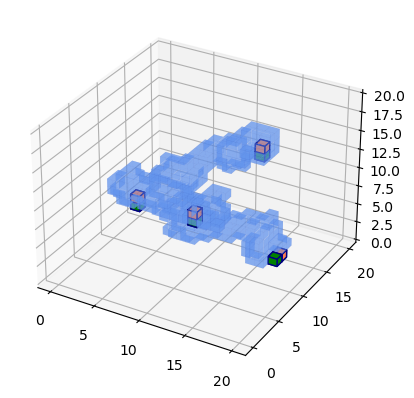

In [88]:
# load pdb with mdtraj
tetra = md.load('./pdbs/tetra.pdb')
traj = tetra.atom_slice(tetra.top.select('chainid 0 1 2 3')).center_coordinates() # remove solvent and center coordinates

# convert  atomic coordinates as a numpy array to binary voxel array
n = 20
voxelgrid, binary_voxels= xyz_to_binary_voxel(traj.xyz[0], n=n)

# get the coordinates of the center of mass of the QGR residues
QGR_resids = [[111,112,113],[248,249,250],[522,523,524],[385,386,387]] # for each chain the QGR residues
coms = get_COM_selections(traj, QGR_resids)
print(coms)
# get the voxel indices and voxel numbers of the center of mass of the QGR residues
voxel_indices, voxel_n = get_voxel_indices(coms, voxelgrid)

# get the control points and their voxel numbers for the center of mass of the QGR residues
control_points, ids = get_control_points(voxel_indices, binary_voxels, voxelgrid, voxel_n)

visualize_voxels(voxelgrid, voxel_n, ids, n)

### Part 2: Use voxel representation and control points to find path with collision detection

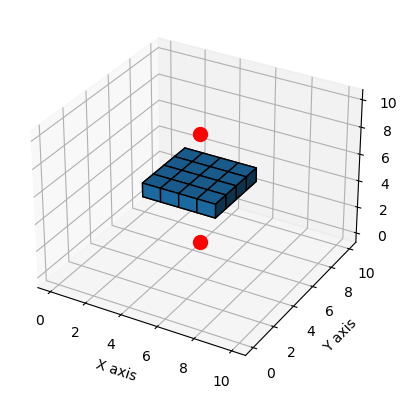

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_voxel_with_obstacle(grid_size=10, square_start=3, square_size = 4):
    # Define the size of the voxel grid
    # Define the square's position and size, obsticke

    # Initialize the voxel grid with zeros (empty space)
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=bool)

    # Create a square in the middle of the grid
    voxel_grid[square_start:square_start+square_size, square_start:square_start+square_size, grid_size//2] = True

    return voxel_grid

def plot_voxel_grid(voxel_grid, points=None):
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Visualize the voxels
    ax.voxels(voxel_grid, edgecolor='k')

    # Setting the labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # plot point A and B as scatters
    for point in points:
        ax.scatter(point[0], point[1], point[2], color='r', s=100)



# Generate the voxel grid
voxel_grid = generate_voxel_with_obstacle()

# Starting points 
point_A = (5,5,1)
point_B = (5,5,9)

# Show plot
plot_voxel_grid(voxel_grid, points=[point_A, point_B])


In [90]:
import numpy as np
from heapq import heappush, heappop

# Function to calculate the length of a path
def path_length(path):
    length = 0
    for i in range(1, len(path)):
        # Calculate the Euclidean distance between consecutive points in the path
        length += np.sqrt(sum((np.array(path[i]) - np.array(path[i-1])) ** 2))
    return length

# Function to calculate the Euclidean distance (heuristic) between two points
def heuristic(a, b):
    # Calculate the Euclidean distance between points 'a' and 'b'
    return np.sqrt(sum((np.array(a) - np.array(b)) ** 2))

# A* algorithm implementation
def astar(array, start, goal):
    neighbors = [(0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0), (0, 0, 1), (0, 0, -1)]

    close_set = set()  # Set to store explored nodes
    came_from = {}     # Dictionary to store the path for each node
    gscore = {start: 0}  # Dictionary to store the cost to reach each node from the start
    fscore = {start: heuristic(start, goal)}  # Dictionary to store the total estimated cost for each node
    oheap = []  # Priority queue to store nodes to be explored

    heappush(oheap, (fscore[start], start))  # Add the start node to the priority queue
    
    while oheap:

        current = heappop(oheap)[1]  # Get the node with the lowest estimated cost from the priority queue

        if current == goal:
            # Reconstruct the path from the goal node to the start node
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)  # Mark the current node as explored
        for i, j, k in neighbors:
            neighbor = current[0] + i, current[1] + j, current[2] + k  # Calculate the coordinates of the neighbor node
            
            # Calculate the tentative cost to reach the neighbor node from the current node
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if 0 <= neighbor[2] < array.shape[2]:
                        if array[neighbor[0]][neighbor[1]][neighbor[2]] == True:
                            continue
                    else:
                        # Skip neighbors outside of the array bounds in the z direction
                        continue
                else:
                    # Skip neighbors outside of the array bounds in the y direction
                    continue
            else:
                # Skip neighbors outside of the array bounds in the x direction
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                # Skip this neighbor if it has already been explored or if the tentative cost is higher
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                # Update the path and cost information for the neighbor node
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))  # Add the neighbor to the priority queue
                
    return False  # Return False if no path is found

Path length: 11.0


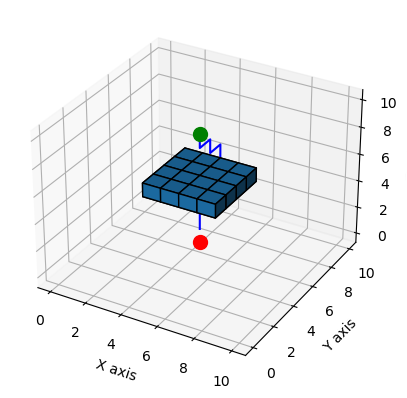

In [91]:


point_A = (5, 5, 1)
point_B = (5, 5, 9)

# Run A* algorithm to find the path
path = astar(voxel_grid, point_A, point_B)
path_length = path_length(path)
print('Path length: {}'.format(path_length))

# Plotting the path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualize the voxels
ax.voxels(voxel_grid, edgecolor='k')

# Plot points A and B
ax.scatter(point_A[0], point_A[1], point_A[2], color='r', s=100) # Point A
ax.scatter(point_B[0], point_B[1], point_B[2], color='g', s=100) # Point B

# Plot the path
if path:
    path_x = [p[0] for p in path]
    path_y = [p[1] for p in path]
    path_z = [p[2] for p in path]
    ax.plot(path_x, path_y, path_z, color="blue")

# Setting the labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show plot
plt.show()

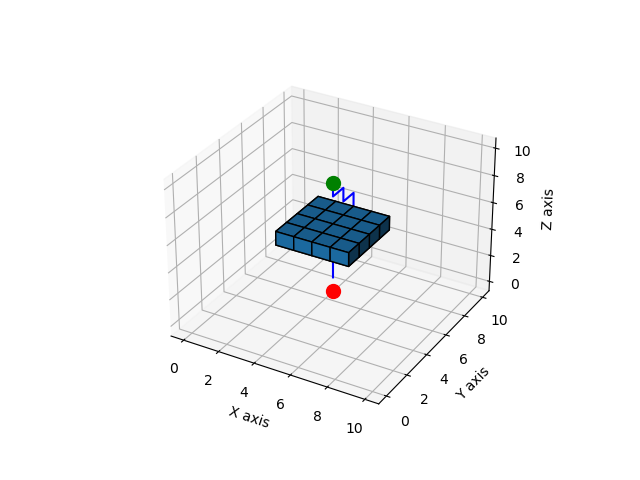

In [92]:
%matplotlib ipympl
# Plotting the path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualize the voxels
ax.voxels(voxel_grid, edgecolor='k')

# Plot points A and B
ax.scatter(point_A[0], point_A[1], point_A[2], color='r', s=100) # Point A
ax.scatter(point_B[0], point_B[1], point_B[2], color='g', s=100) # Point B

# Plot the path
if path:
    path_x = [p[0] for p in path]
    path_y = [p[1] for p in path]
    path_z = [p[2] for p in path]
    ax.plot(path_x, path_y, path_z, color="blue")

# Setting the labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show plot
plt.show()

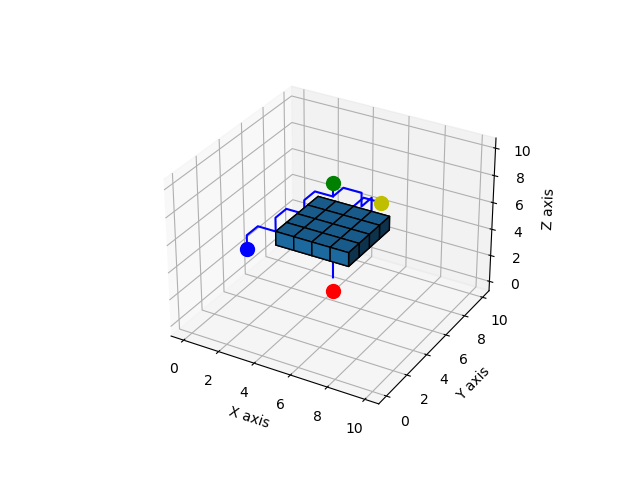

In [93]:
from itertools import permutations

# Function to calculate total path length for a given sequence of points
def calculate_total_path_length(paths):
    total_length = 0
    for path in paths:
        if path:
            total_length += len(path)
    return total_length

# Function to solve the TSP using a heuristic approach
def tsp_nearest_neighbor(grid, points):
    # Calculate shortest paths between all pairs of points
    shortest_paths = {(p1, p2): astar(grid, p1, p2) for p1 in points for p2 in points if p1 != p2}

    # Initialize variables for the best path
    best_path = None
    min_path_length = float('inf')

    # Check all permutations of points
    for perm in permutations(points):
        # Calculate the total length of this permutation
        total_length = 0
        for i in range(len(perm) - 1):
            path = shortest_paths[(perm[i], perm[i + 1])]
            if path:
                total_length += len(path)
            else:
                total_length = float('inf')
                break

        # Check if this is the shortest path so far
        if total_length < min_path_length:
            best_path = perm
            min_path_length = total_length

    return best_path

# Additional points C and D
point_C = (2, 2, 5)
point_D = (6, 8, 6)

# List of points in sequence
points = [point_A, point_B, point_C, point_D]
points_colors = ['r', 'g', 'b', 'y']

# Solve the TSP
tsp_path = tsp_nearest_neighbor(voxel_grid, points)

# Plotting the TSP path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualize the voxels
ax.voxels(voxel_grid, edgecolor='k')

# Plot the points
for point, color in zip(points, points_colors):
    ax.scatter(point[0], point[1], point[2], color=color, s=100)

# Plot the TSP path
if tsp_path:
    for i in range(len(tsp_path) - 1):
        path = astar(voxel_grid, tsp_path[i], tsp_path[i + 1])
        if path:
            path_x = [p[0] for p in path]
            path_y = [p[1] for p in path]
            path_z = [p[2] for p in path]
            ax.plot(path_x, path_y, path_z, color="blue")

# Setting the labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show plot
plt.show()


In [ ]:
from itertools import permutations

class VoxelPathFinder:
    def __init__(self, grid_size, occupied_voxels):
        """
        Initialize the voxel grid.
        :param grid_size: Size of the voxel grid.
        :param occupied_voxels: List of tuples representing the occupied voxels.
        """
        self.grid_size = grid_size
        self.voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=bool)
        for voxel in occupied_voxels:
            self.voxel_grid[voxel] = True

    @staticmethod
    def heuristic(a, b):
        """
        Calculate Euclidean distance (heuristic) between two points.
        """
        return np.sqrt(sum((np.array(a) - np.array(b)) ** 2))

    def astar(self, start, goal):
        """
        A* algorithm implementation for pathfinding in the voxel grid.
        """
        neighbors = [(0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0), (0, 0, 1), (0, 0, -1)]

        close_set = set()
        came_from = {}
        gscore = {start: 0}
        fscore = {start: self.heuristic(start, goal)}
        oheap = []

        heappush(oheap, (fscore[start], start))
        
        while oheap:
            current = heappop(oheap)[1]

            if current == goal:
                data = []
                while current in came_from:
                    data.append(current)
                    current = came_from[current]
                return data

            close_set.add(current)
            for i, j, k in neighbors:
                neighbor = current[0] + i, current[1] + j, current[2] + k            
                tentative_g_score = gscore[current] + self.heuristic(current, neighbor)
                if 0 <= neighbor[0] < self.grid_size:
                    if 0 <= neighbor[1] < self.grid_size:
                        if 0 <= neighbor[2] < self.grid_size:                
                            if self.voxel_grid[neighbor[0]][neighbor[1]][neighbor[2]] == True:
                                continue
                        else:
                            continue
                    else:
                        continue
                else:
                    continue
                
                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                    continue
                
                if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + self.heuristic(neighbor, goal)
                    heappush(oheap, (fscore[neighbor], neighbor))
                
        return False

    def find_path_sequence(self, points):
        """
        Find the shortest path for a sequence of points.
        """
        paths = []
        for i in range(len(points) - 1):
            start = points[i]
            end = points[i + 1]
            path = self.astar(start, end)
            if path:
                paths.append(path)
            else:
                return None  # No path found
        return paths

    def tsp_nearest_neighbor(self, points):
        """
        Solve the TSP using the nearest neighbor heuristic.
        """
        # Calculate shortest paths between all pairs of points
        shortest_paths = {(p1, p2): self.astar(p1, p2) for p1 in points for p2 in points if p1 != p2}

        # Initialize variables for the best path
        best_path = None
        min_path_length = float('inf')

        # Check all permutations of points
        for perm in permutations(points):
            total_length = sum(len(shortest_paths[(perm[i], perm[i + 1])]) for i in range(len(perm) - 1))
            if total_length < min_path_length:
                best_path = perm
                min_path_length = total_length

        return best_path



In [ ]:
# Demo and tests for the VoxelPathFinder class

# Create a demo function
def demo_voxel_pathfinder():
    # Initialize a voxel grid of size 10x10x10 with some occupied voxels
    grid_size = 10
    occupied_voxels = [(x, y, z) for x in range(3, 7) for y in range(3, 7) for z in [grid_size // 2]]
    pathfinder = VoxelPathFinder(grid_size, occupied_voxels)

    # Define points
    point_A = (5, 5, 1)
    point_B = (5, 5, 9)
    point_C = (2, 2, 5)
    point_D = (7, 7, 7)
    points = [point_A, point_B, point_C, point_D]

    # Test 1: Shortest path between two points
    print("Test 1: Shortest path between Point A and Point B")
    path_A_B = pathfinder.astar(point_A, point_B)
    if path_A_B:
        print(f"Path found between Point A and Point B of lengt: {len(path_A_B)-1}, {path_A_B}")
    else:
        print("No path found between Point A and Point B")

    # Test 2: Shortest path in sequence through a list of points
    print("\nTest 2: Shortest path sequence through Points A, B, C, D")
    path_sequence = pathfinder.find_path_sequence(points)
    if path_sequence:
        print(f"Path sequence found of length {len(path_sequence[0])-1}: {path_sequence}")
    else:
        print("No path sequence found")

    # Test 3: Solving the TSP
    print("\nTest 3: Solving the TSP for Points A, B, C, D")
    tsp_path = pathfinder.tsp_nearest_neighbor(points)
    if tsp_path:
        print(f"TSP path found: {tsp_path}")
    else:
        print("No TSP path found")

# Run the demo
demo_voxel_pathfinder()


In [ ]:
import heapq
import numpy as np

def heuristic(a, b):
    """
    Calculate the Manhattan distance between two points.
    """
    return sum(abs(val1-val2) for val1, val2 in zip(a,b))

def a_star_search(voxel_array, start, goal):
    """
    A* pathfinding algorithm to find the shortest path in a voxel array avoiding voxels with value 1.
    """
    neighbors = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]

    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    while open_set:
        current = heapq.heappop(open_set)[1]
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]

        for dx, dy, dz in neighbors:
            neighbor = (current[0] + dx, current[1] + dy, current[2] + dz)

            # Check if the neighbor is within the bounds of the voxel array and not an obstacle
            if 0 <= neighbor[0] < voxel_array.shape[0] and \
               0 <= neighbor[1] < voxel_array.shape[1] and \
               0 <= neighbor[2] < voxel_array.shape[2] and \
               voxel_array[neighbor] == 0:

                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None  # Path not found

In [ ]:
import numpy as np

def create_voxel_array(size, obstacle_type, obstacle_params):
    """
    Create a voxel array of the given size and insert an obstacle of the specified type.

    :param size: Size of the voxel array (tuple of 3 integers).
    :param obstacle_type: Type of the obstacle ('cube' or 'sphere').
    :param obstacle_params: Parameters for the obstacle (dict).
    :return: Voxel array with an obstacle.
    """
    voxel_array = np.zeros(size, dtype=np.uint8)

    if obstacle_type == 'cube':
        x, y, z, cube_size = obstacle_params['x'], obstacle_params['y'], obstacle_params['z'], obstacle_params['size']
        voxel_array[x:x+cube_size, y:y+cube_size, z:z+cube_size] = 1

    elif obstacle_type == 'sphere':
        center, radius = obstacle_params['center'], obstacle_params['radius']
        for x in range(size[0]):
            for y in range(size[1]):
                for z in range(size[2]):
                    if np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2) <= radius:
                        voxel_array[x, y, z] = 1

    return voxel_array

n = 10
# Example of creating a voxel array with a cubic obstacle
voxel_array_cube = create_voxel_array(size=(n, n, n), obstacle_type='cube', obstacle_params={'x': 3, 'y': 3, 'z': 3, 'size': 3})

# Example of creating a voxel array with a spherical obstacle
voxel_array_sphere = create_voxel_array(size=(n, n, n), obstacle_type='sphere', obstacle_params={'center': (5, 5, 5), 'radius': 3})

# Displaying a slice of the voxel array for visualization
voxel_array_cube_slice = voxel_array_cube[:, :, 5]
voxel_array_sphere_slice = voxel_array_sphere[:, :, 5]
#voxel_array_cube_slice, voxel_array_sphere_slice

In [ ]:
voxel_array_blocked = create_voxel_array(size=(10, 10, 10), obstacle_type='cube', obstacle_params={'x': 1, 'y': 1, 'z': 1, 'size': 12})
voxel_array_blocked_slice = voxel_array_blocked[:, :, 3]
voxel_array_blocked_slice

In [ ]:
import unittest

# Test cases for the a_star_search function
class TestAStarSearch(unittest.TestCase):
    def test_pathfinding_around_cube(self):
        start, goal = (0, 0, 0), (9, 9, 9)
        path = a_star_search(voxel_array_cube, start, goal)
        self.assertIsNotNone(path)
        self.assertTrue(all(voxel_array_cube[point] == 0 for point in path))

    def test_pathfinding_around_sphere(self):
        start, goal = (0, 0, 0), (9, 9, 9)
        path = a_star_search(voxel_array_sphere, start, goal)
        self.assertIsNotNone(path)
        self.assertTrue(all(voxel_array_sphere[point] == 0 for point in path))

    def test_no_path_through_cube(self):
        # Block all paths by placing a cube in the center
        voxel_array_blocked = create_voxel_array(size=(10, 10, 10), obstacle_type='cube', obstacle_params={'x': 4, 'y': 4, 'z': 4, 'size': 3})
        start, goal = (0, 0, 0), (9, 9, 9)
        path = a_star_search(voxel_array_blocked, start, goal)
        self.assertIsNone(path)

TestAStarSearch().test_pathfinding_around_cube()
TestAStarSearch().test_pathfinding_around_sphere()
#TestAStarSearch().test_no_path_through_cube()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def calculate_path_length(path):
    """
    Calculate the length of a path in a voxel grid. 
    The length is equal to the number of steps in the path.

    :param path: The path as a list of points (tuples).
    :return: The length of the path.
    """
    if path is None or len(path) == 0:
        return 0
    return len(path) - 1


def visualize_path(voxel_array, path, start, goal):
    """
    Visualize the pathfinding in a 3D voxel array.

    :param voxel_array: The 3D voxel array with obstacles.
    :param path: The path found by the A* algorithm.
    :param start: Start point of the path.
    :param goal: Goal point of the path.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting obstacles
    for x in range(voxel_array.shape[0]):
        for y in range(voxel_array.shape[1]):
            for z in range(voxel_array.shape[2]):
                if voxel_array[x, y, z] == 1:
                    print(x,y,z)
                    ax.scatter(x, y, z, color='red', s=100)  # Obstacle points

    # Plotting the path
    if path is not None:
        path_x, path_y, path_z = zip(*path)
        ax.plot(path_x, path_y, path_z, color='blue', linewidth=3)  # Path line

    # Plotting start and goal points
    ax.scatter(*start, color='green', s=100, label='Start')  # Start point
    ax.scatter(*goal, color='gold', s=100, label='Goal')   # Goal point

    # Setting labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('A* Pathfinding Visualization')

    # Legend
    ax.legend()

    plt.show()

n = 20
# Example of creating a voxel array with a cubic obstacle
voxel_array_cube = create_voxel_array(size=(n, n, n), obstacle_type='cube', obstacle_params={'x': 1, 'y': 3, 'z': 9, 'size': 0})

# Visualize the path for the test case with a cubic obstacle
start, goal = (0, 0, 0), (9, 9, 9)
path = a_star_search(voxel_array_cube, start, goal)
print(f'Length of path: {calculate_path_length(path)}')
visualize_path(voxel_array_cube, path, start, goal)

In [ ]:
voxel_array_cube

In [ ]:

    
def find_path_through_control_points(voxel_array, points):
    total_path = []
    for i in range(len(points) - 1):
        start = tuple(points[i])
        goal = tuple(points[i + 1])
        segment_path = a_star_search(voxel_array, start, goal)
        if segment_path is None:
            return None  # Path not found for one of the segments
        total_path.extend(segment_path)
    return total_path

def plot_path_in_voxel_space(voxel_array, path, start, goal, control_points=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the obstacles
    obstacles_x, obstacles_y, obstacles_z = np.where(voxel_array == 1)
    ax.scatter(obstacles_x, obstacles_y, obstacles_z, zdir='z', c='red', marker='o', label='Obstacles')

    # Plot the path
    if path:
        path_x, path_y, path_z = zip(*path)
        ax.plot(path_x, path_y, path_z, color='blue', linewidth=2, label='Path')

    # Plot the start and goal points
    ax.scatter(*start, color='green', s=100, label='Start')
    ax.scatter(*goal, color='gold', s=100, label='Goal')

    if control_points is not None:
        control_points_x, control_points_y, control_points_z = zip(*control_points)
        ax.scatter(control_points_x, control_points_y, control_points_z, color='gray', s=100, label='Control Points')

    # Setting labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()

    # Show the plot
    plt.show()

In [ ]:

# Convert your control points to tuples if they are numpy arrays
control_points = [tuple(point) for point in control_points]

start = tuple(control_points[0])  # Start index
goal = tuple(control_points[2])   # Goal index

# Now use the function with the converted control points
path_with_control_points = find_path_through_control_points(binary_voxels, control_points)

# Proceed with plotting if a path is found
if path_with_control_points:
    plot_path_in_voxel_space(binary_voxels, path_with_control_points, start, goal)
else:
    print("No path found through the control points.")

In [ ]:
# reshape the voxel array to a 3D array containingt the centers of the voxels
point_cloud = traj.xyz[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
path_xyz = np.array([voxelgrid.voxel_centers.reshape(n,n,n,3)[i] for i in path_with_control_points])
path_xyz.shape
ax.scatter(path_xyz[:,0], path_xyz[:,1], path_xyz[:,2], color='blue', s=100, label='Path')
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], color='red', s=1, label='Path')